In [1]:
from datetime import datetime, timedelta
from tqdm import tqdm_notebook as tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import lightgbm as lgb

SEED = 42

In [2]:
df_train = pd.read_pickle('../input/ashrae-preprocessing/train.pkl')
df_weather = pd.read_pickle('../input/ashrae-preprocessing/weather.pkl')
df_building_metadata = pd.read_pickle('../input/ashrae-preprocessing/building_metadata.pkl')

df_train = df_train.merge(df_building_metadata, on='building_id', how='left')
df_train = df_train.merge(df_weather, on=['site_id', 'timestamp'], how='left')

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

del df_building_metadata, df_weather
gc.collect()

Training Set Shape = (19426418, 26)
Training Set Memory Usage = 1704.44 MB


16

In [3]:
drop_cols = ['sea_level_pressure', 'wind_direction', 'IsHoliday']
df_train.drop(columns=drop_cols, inplace=True)
    
gc.collect()
print(f'{len(drop_cols)} columns are dropped.')

3 columns are dropped.


In [4]:
target = np.log1p(df_train['meter_reading'])
df_train.drop(columns=['meter_reading'], inplace=True)

In [5]:
lgb_param = {
    'num_leaves': 2**9, 
    'learning_rate': 0.05,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'feature_fraction_bynode': 0.7,
    'min_data_in_leaf': 1000,
    'max_depth': -1, 
    'objective': 'regression',
    'seed': SEED,
    'feature_fraction_seed': SEED,
    'bagging_seed': SEED,
    'drop_seed': SEED,
    'data_random_seed': SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
}

In [6]:
%%time

CATEGORICALS = ['building_id', 'meter', 'primary_use', 'HourOfDay', 'DayOfWeek', 'site_id']
N = 5
kf = KFold(n_splits=N)

importance = pd.DataFrame(np.zeros((df_train.shape[1] - 1, N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_train.drop(columns=['timestamp']).columns)
scores = []
oof = np.zeros(df_train.shape[0])
models = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(df_train), 1):
    print('Fold {}'.format(fold))
              
    trn_data = lgb.Dataset(df_train.iloc[trn_idx, :].drop(columns=['timestamp']), label=target.iloc[trn_idx], categorical_feature=CATEGORICALS)
    val_data = lgb.Dataset(df_train.iloc[val_idx, :].drop(columns=['timestamp']), label=target.iloc[val_idx], categorical_feature=CATEGORICALS)   
    
    model = lgb.train(lgb_param, trn_data, 200, valid_sets=[trn_data, val_data], verbose_eval=50)
    models.append(model)

    predictions = model.predict(df_train.iloc[val_idx, :].drop(columns=['timestamp']), num_iteration=model.best_iteration) 
    importance.iloc[:, fold - 1] = model.feature_importance()
    oof[val_idx] = predictions

    score = np.sqrt(mean_squared_error(target.iloc[val_idx].values, predictions))
    scores.append(score)
    print('Fold {} RMSLE {}\n'.format(fold, score))
    
    del trn_data, val_data, predictions
    gc.collect()
    
print('Mean RMSLE {} [STD:{}]'.format(np.mean(scores), np.std(scores)))
print('OOF RMSLE {}'.format(np.sqrt(mean_squared_error(target, oof))))

Fold 1
[50]	training's rmse: 0.8166	valid_1's rmse: 0.95881
[100]	training's rmse: 0.724998	valid_1's rmse: 0.878599
[150]	training's rmse: 0.700063	valid_1's rmse: 0.868293
[200]	training's rmse: 0.687881	valid_1's rmse: 0.866674
Fold 1 RMSLE 0.8666737472059586

Fold 2
[50]	training's rmse: 0.814109	valid_1's rmse: 0.886136
[100]	training's rmse: 0.719241	valid_1's rmse: 0.836089
[150]	training's rmse: 0.690682	valid_1's rmse: 0.828012
[200]	training's rmse: 0.676385	valid_1's rmse: 0.827239
Fold 2 RMSLE 0.8272393693604142

Fold 3
[50]	training's rmse: 0.821985	valid_1's rmse: 0.875298
[100]	training's rmse: 0.734771	valid_1's rmse: 0.781815
[150]	training's rmse: 0.708635	valid_1's rmse: 0.765303
[200]	training's rmse: 0.696252	valid_1's rmse: 0.759704
Fold 3 RMSLE 0.759703525473574

Fold 4
[50]	training's rmse: 0.815652	valid_1's rmse: 0.869159
[100]	training's rmse: 0.729467	valid_1's rmse: 0.800713
[150]	training's rmse: 0.700614	valid_1's rmse: 0.789469
[200]	training's rmse: 0.6

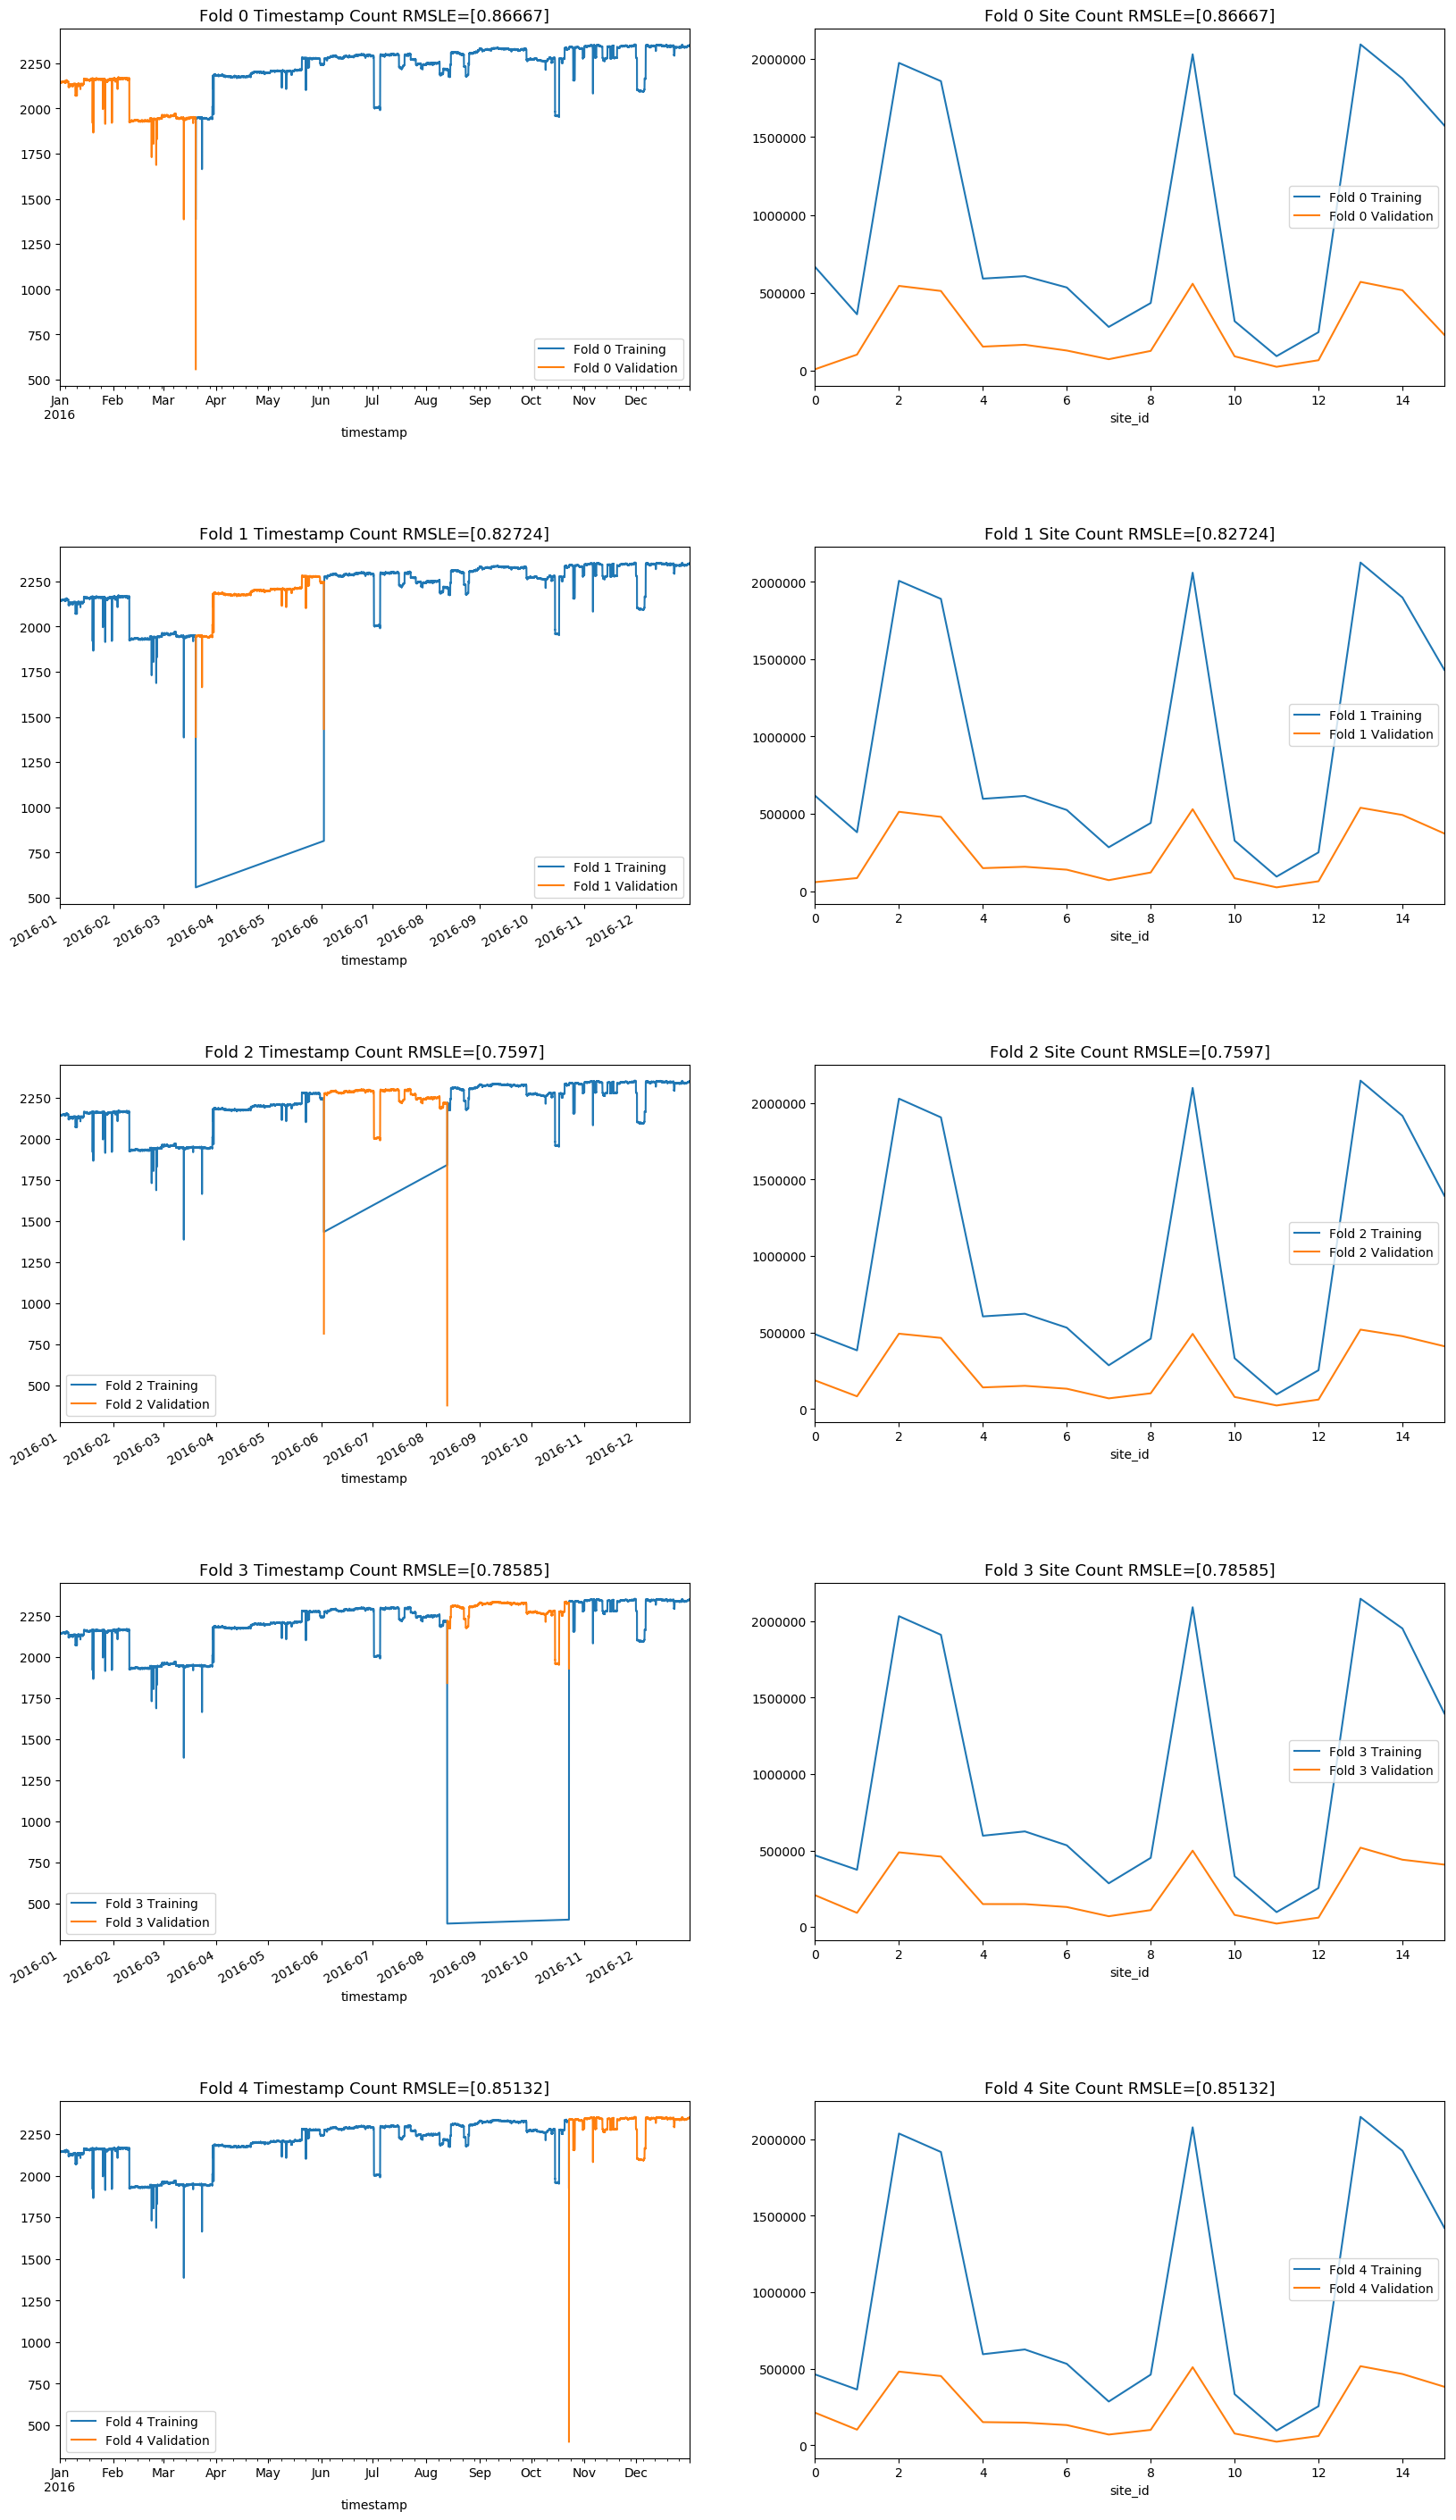

In [7]:
splits = [split for split in kf.split(df_train)]

fig, axes = plt.subplots(ncols=2, nrows=N, figsize=(20, 40), dpi=100)

for i, split in enumerate(splits):
    df_train.loc[split[0]].groupby(['timestamp'])['timestamp'].count().plot(label=f'Fold {i} Training', ax=axes[i][0])
    df_train.loc[split[1]].groupby(['timestamp'])['timestamp'].count().plot(label=f'Fold {i} Validation', ax=axes[i][0])

    df_train.loc[split[0]].groupby(['site_id'])['site_id'].count().plot(label=f'Fold {i} Training', ax=axes[i][1])
    df_train.loc[split[1]].groupby(['site_id'])['site_id'].count().plot(label=f'Fold {i} Validation', ax=axes[i][1])
    
    axes[i][0].legend()
    axes[i][1].legend()
    axes[i][0].set_title(f'Fold {i} Timestamp Count RMSLE=[{np.round(scores[i], 5)}]', fontsize=13)
    axes[i][1].set_title(f'Fold {i} Site Count RMSLE=[{np.round(scores[i], 5)}]', fontsize=13)

    plt.subplots_adjust(hspace=0.45)

plt.show()

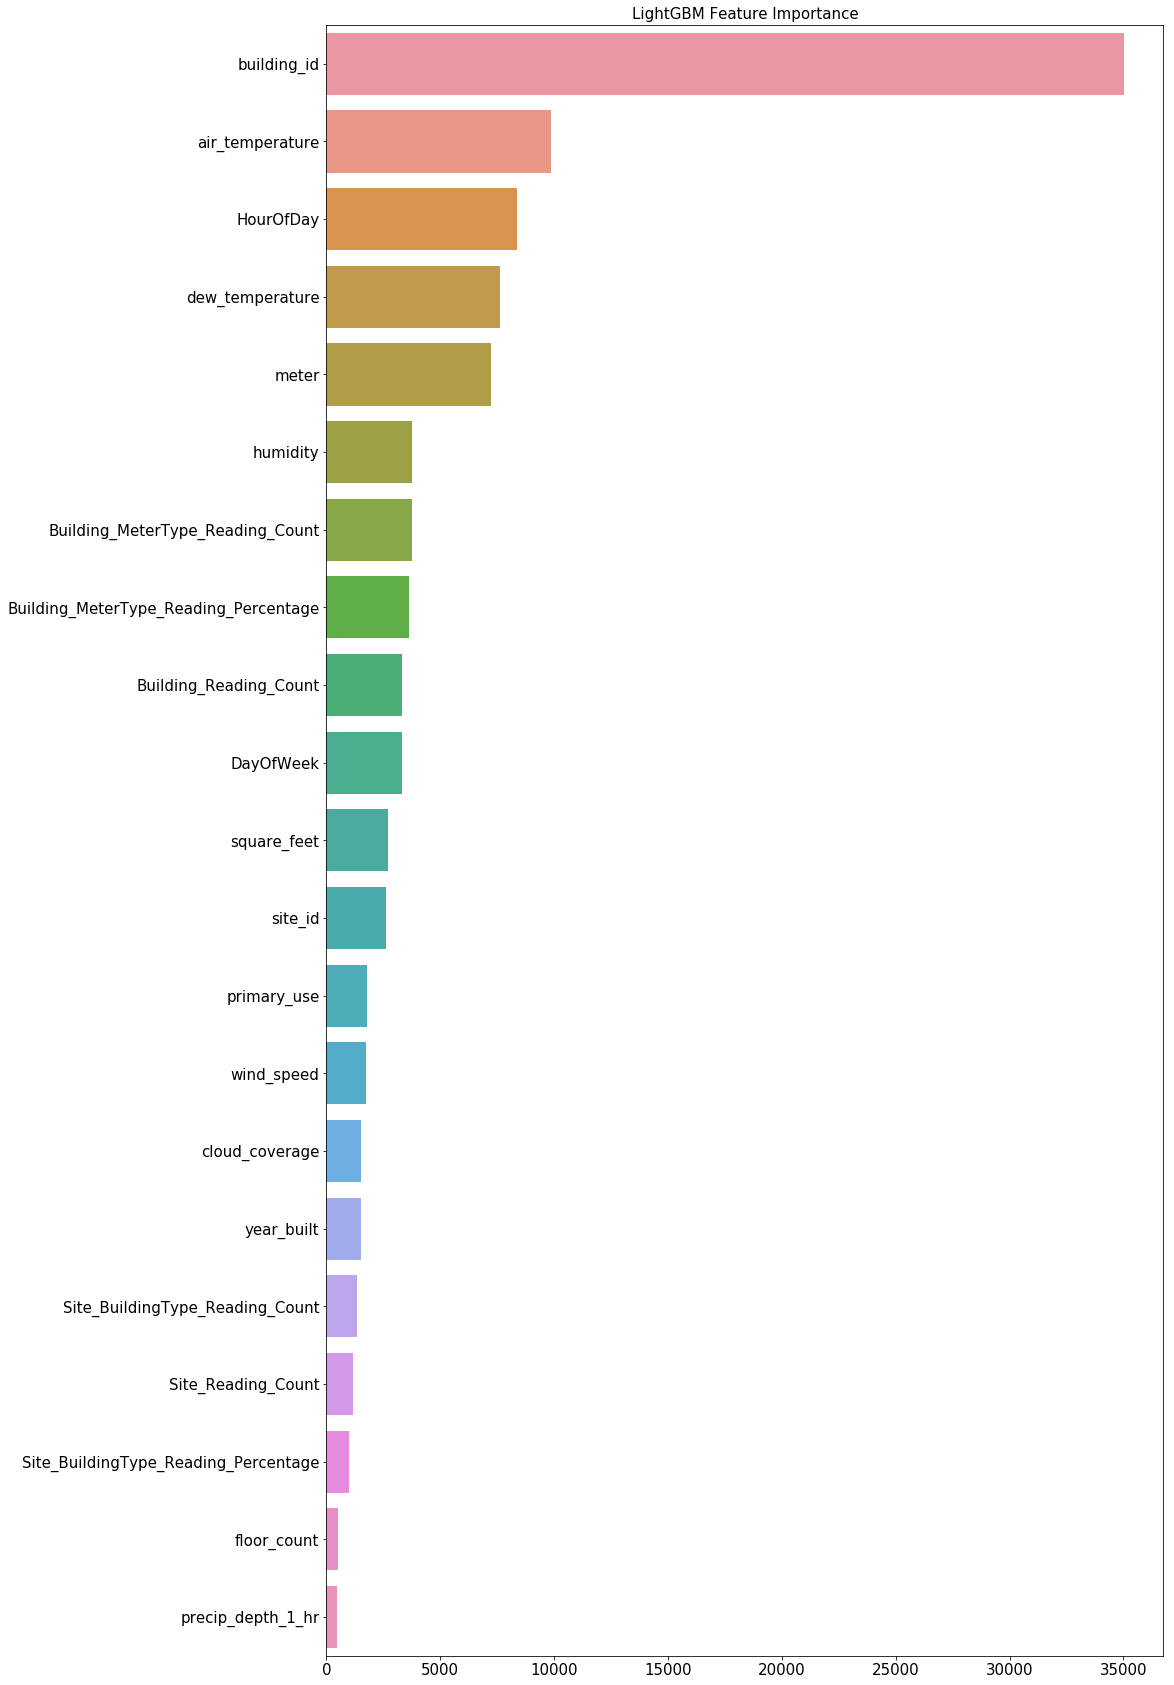

In [8]:
importance['Mean_Importance'] = importance.sum(axis=1) / N
importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 30))
sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('LightGBM Feature Importance', size=15)

plt.show()

In [9]:
df_test = pd.read_pickle('../input/ashrae-preprocessing/test.pkl')
df_weather = pd.read_pickle('../input/ashrae-preprocessing/weather.pkl')
df_building_metadata = pd.read_pickle('../input/ashrae-preprocessing/building_metadata.pkl')

df_test = df_test.merge(df_building_metadata, on='building_id', how='left')
df_test = df_test.merge(df_weather, on=['site_id', 'timestamp'], how='left')

print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

del df_building_metadata, df_weather, df_train, target
gc.collect()

Test Set Shape = (41697600, 26)
Test Set Memory Usage = 3658.47 MB


5387

In [10]:
drop_cols = ['sea_level_pressure', 'wind_direction', 'meter_reading', 'timestamp', 'IsHoliday']

df_test.drop(columns=drop_cols, inplace=True)
    
gc.collect()    
print(f'{len(drop_cols)} columns are dropped.')

5 columns are dropped.


In [11]:
N_SAMPLES = len(df_test)
ITERATIONS = 50
batch_size = N_SAMPLES // ITERATIONS

y_pred = []

for i in tqdm(range(ITERATIONS)):
    start = i * batch_size
    fold_preds = [np.expm1(model.predict(df_test.iloc[start:start + batch_size])) for model in models]
    y_pred.extend(np.mean(fold_preds, axis=0))

In [12]:
submission = pd.read_csv('../input/ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = np.clip(y_pred, a_min=0, a_max=None)
submission.to_csv('submission.csv', index=False)
submission['meter_reading'].describe()

count    4.169760e+07
mean     3.998709e+02
std      1.783978e+03
min      0.000000e+00
25%      2.184900e+01
50%      8.179248e+01
75%      2.601031e+02
max      9.732898e+04
Name: meter_reading, dtype: float64